## 通过能耗数据反算总阻力RT

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from class_total_resistance_estimatoin import *
from class_calm_water_resistance_estimatoin import *

### 先计算功率

In [ ]:
# 先计算P effective
# 
# # 定义
# etaR = 1.0 # 准确计算较复杂，但整体波动小，经验值是1-1.07或者0.98
# etaO = 0.60 # 可以算，但需要知道V_A和thruster force T的具体意义，经验值0.55-0.7
# etaS = 0.99 # 无计算公式，取经验值，0.99，0.98，0.95-0.96三种情况
# etaH = 1.1 # 要计算t, w，1-t/1-w,需要知道力和速度的关系。
# SOFC = 200 # g/kwh
# eta = etaR*etaO*etaS*etaH

# # 求P_effective
# df_fuel = pd.read_csv('/content/Ship-fuel-prediction/raw_data/mrv.csv')
# df_fuel['input_date'] = pd.to_datetime(df_fuel['input_date'],format='ISO8601')
# df_fuel = df_fuel[df_fuel['daily_voyage_time_mrv'] >= 24]
# df_fuel = df_fuel.dropna(axis=0, subset = ['daily_fuel_mrv'])
# df_fuel = df_fuel.reset_index(drop=True)
# df_fuel = df_fuel.drop(4747)
# df_fuel = df_fuel.reset_index(drop=True)
# years = df_fuel['input_date'].dt.year
# months = df_fuel['input_date'].dt.month
# days = df_fuel['input_date'].dt.day
# df_fuel['daily_fuel_mrv'] = df_fuel['daily_fuel_mrv']*1000/24/SOFC*1000 # 一天的油耗(吨)乘10的3次方变为kg，转化成每个小时消耗,kg/h，再根据原公式除以(SOFC*10-3)获得功率，单位千瓦
# df_fuel['daily_fuel_mrv'] = df_fuel['daily_fuel_mrv']*eta # 计算P effective 单位千瓦
# df_fuel = df_fuel.rename(columns = {'daily_fuel_mrv': 'P_e'})
# df_fuel.to_csv('/content/Ship-fuel-prediction/processed/mrv_P_effective.csv')

<!-- # 求P_effective
# 定义
etaR = 1.0 # 准确计算较复杂，但整体波动小，经验值是1-1.07或者0.98
etaO = 0.60 # 可以算，但需要知道V_A和thruster force T的具体意义，经验值0.55-0.7
etaS = 0.99 # 无计算公式，取经验值，0.99，0.98，0.95-0.96三种情况
etaH = 1.1 # 要计算t, w，1-t/1-w,需要知道力和速度的关系。
SOFC = 200 # g/kwh
eta = etaR*etaO*etaS*etaH

# 求P_effective
df_fuel = pd.read_csv('/raw_data/mrv.csv')
df_fuel['input_date'] = pd.to_datetime(df_fuel['input_date'],format='ISO8601')
df_fuel = df_fuel[df_fuel['daily_voyage_time_mrv'] >= 24]
df_fuel = df_fuel.dropna(axis=0, subset = ['daily_fuel_mrv'])
df_fuel = df_fuel.reset_index(drop=True)
df_fuel = df_fuel.drop(4747) # 这一行重复了
df_fuel = df_fuel.reset_index(drop=True)
years = df_fuel['input_date'].dt.year
months = df_fuel['input_date'].dt.month
days = df_fuel['input_date'].dt.day
df_fuel['daily_fuel_mrv'] = df_fuel['daily_fuel_mrv']*1000/24/SOFC*1000 # 一天的油耗(吨)乘10的3次方变为kg，转化成每个小时消耗,kg/h，再根据原公式除以(SOFC*10-3)获得功率，单位千瓦
df_fuel['daily_fuel_mrv'] = df_fuel['daily_fuel_mrv']*eta # 计算P effective 单位千瓦
df_fuel = df_fuel.rename(columns = {'daily_fuel_mrv': 'P_e'})
df_fuel.to_csv('/content/Ship-fuel-prediction/processed/mrv_P_effective.csv') -->

In [ ]:
# # 此时还需要知道速度才能求Rtotal,先和AIS数据合并
# df_ais = pd.read_csv('/processed/AIS_hour.csv')
# df_ais = df_ais.drop("Unnamed: 0", axis=1)
# df_ais['postime'] = pd.to_datetime(df_ais['postime'],format='ISO8601')

# years = df_ais['postime'].dt.year
# months = df_ais['postime'].dt.month
# days = df_ais['postime'].dt.day
# num = df_ais['num']
# for i in range(df_ais.shape[0]):
#   temp = df_fuel[(df_fuel['input_date'].dt.year == years[i]) & (df_fuel['input_date'].dt.month == months[i]) & (df_fuel['input_date'].dt.day == days[i]) & (df_fuel['num'] == num[i])]
#   pe = temp['P_e']
#   if not pe.empty:
#     df_ais.loc[i, 'Pe'] = pe.values
#   else:
#     df_ais.loc[i, 'Pe'] = np.nan

# df_ais.to_csv('/processed/AIS_hour_with_P.csv')

### 计算阻力R_total

In [11]:
# 计算Rtotal

df_ais = pd.read_csv('../processed/AIS_hour_with_P.csv')
df_ais = df_ais.drop("Unnamed: 0", axis=1)

def Pe2Rtotal(row):
    """"

    每一行反算R_total函数

    
    """
    cu = row['stream_val']*np.sin(np.deg2rad(row['stream_direction']))
    cv = row['stream_val']*np.cos(np.deg2rad(row['stream_direction']))
    sog = row['SOG']*0.5144 # knot to m/s
    Pe = row['Pe']
    heading_ship = row['heading']
    V_water = speedGPS2Water(sog, heading_ship, cu, cv) 
    r_total = Pe/V_water

    return r_total # 单位千牛
    
df_ais['R_total'] = df_ais.apply(Pe2Rtotal, axis=1)
df_ais.to_csv('../processed/AIS_hour_with_R_total.csv')

/tmp/ipykernel_31352/1231628452.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_total = Pe/V_water


### 计算静水阻力R_calm

In [ ]:
df_ais = pd.read_csv('../processed/AIS_hour_with_R_total.csv')
df_ais = df_ais.drop("Unnamed: 0", axis=1)

def Cal_R_calm(row):
    heading_ship = row['heading']
    cu = row['stream_val']*np.sin(np.deg2rad(row['stream_direction']))
    cv = row['stream_val']*np.cos(np.deg2rad(row['stream_direction']))
    sog = row['SOG']*0.5144

    V_water = speedGPS2Water(sog, heading_ship, cu, cv)
    V_shallow=V_water
    r_calm = calm_water_resistance(V_shallow)

    return r_calm/1000

df_ais['R_calm'] = df_ais.apply(Cal_R_calm, axis=1) # KN

df_processed = df_ais[df_ais['R_total']>df_ais['R_calm']]

/workspaces/Ship-fuel-prediction/src/class_calm_water_resistance_estimatoin.py:153: RuntimeWarning: invalid value encountered in log10
  c_f = 0.075 / pow((np.log10(re_v) - 2), 2.0)
/workspaces/Ship-fuel-prediction/src/class_calm_water_resistance_estimatoin.py:197: RuntimeWarning: invalid value encountered in scalar power
  r_w = h.c1 * h.c2 * h.c5 * ship.Vol * rho_sw * ship.g * np.exp(h.m1 * pow(fn, h.d) + m2 * np.cos(h.lamda * pow(fn, -2.)))
/workspaces/Ship-fuel-prediction/src/class_calm_water_resistance_estimatoin.py:153: RuntimeWarning: divide by zero encountered in log10
  c_f = 0.075 / pow((np.log10(re_v) - 2), 2.0)
/workspaces/Ship-fuel-prediction/src/class_calm_water_resistance_estimatoin.py:195: RuntimeWarning: divide by zero encountered in scalar power
  m2 = h.c15 * ship.Cp * ship.Cp * np.exp(-0.1 * pow(fn, -2.))
/workspaces/Ship-fuel-prediction/src/class_calm_water_resistance_estimatoin.py:197: RuntimeWarning: divide by zero encountered in scalar power
  r_w = h.c1 * h.c2 

In [32]:
df_processed = df_processed.reset_index(drop=True)

# 计算R_added
def Cal_R_added(row):
    R_total = row['R_total']
    R_calm = row['R_calm']
    R_added = R_total - R_calm
    return R_added


df_processed['R_added'] = df_processed.apply(Cal_R_added, axis=1) # KN
df_processed.to_csv('AIS_hour_R_added.csv')

<Axes: >

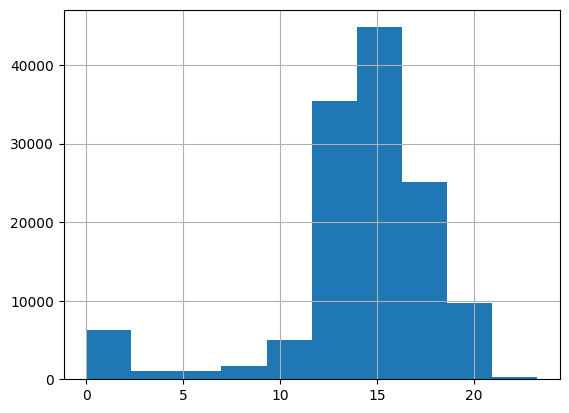

In [44]:
df_processed.SOG.hist()

<Axes: xlabel='SOG'>

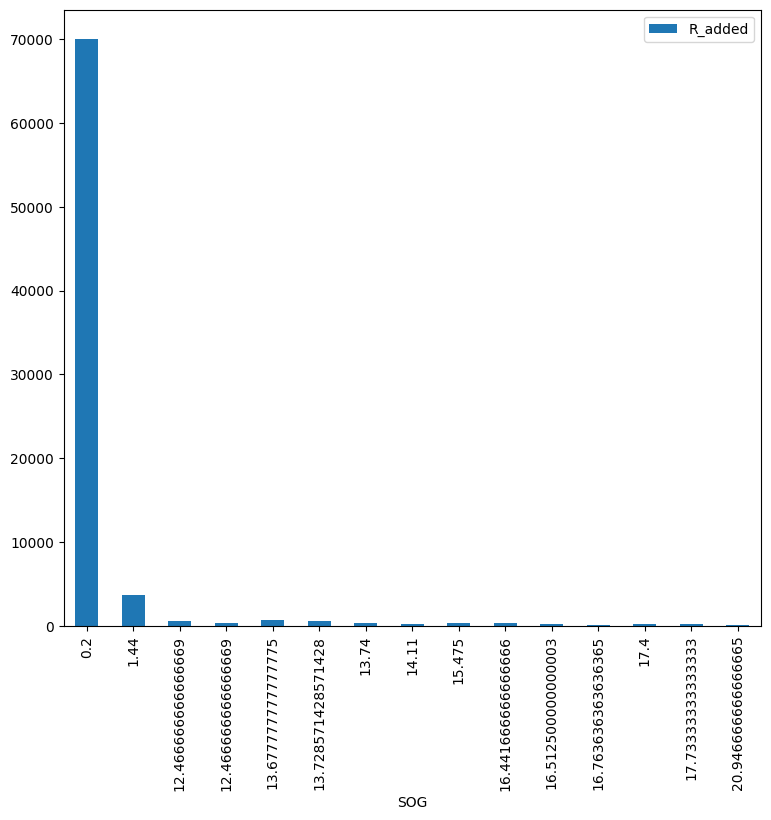

In [42]:
sample = df_processed.sample(n=15)
sample = sample.sort_values(by = 'SOG',axis = 0,ascending = True)

sample.plot(x="SOG", y=["R_added"], kind="bar", figsize=(9, 8))


In [27]:
df_fuel = pd.read_csv('../raw_data/mrv.csv')
df_fuel

,input_date,daily_dist_mrv,daily_voyage_time_mrv,daily_speed_mrv,daily_fuel_mrv,num
0,2021-01-02 04:00:00+00:00,169.0,13.0,13.00,41.39,1
1,2021-01-03 04:00:00+00:00,128.0,9.4,13.62,34.59,1
2,2021-01-04 04:00:00+00:00,335.0,24.0,13.96,71.40,1
3,2021-01-05 04:00:00+00:00,311.0,24.0,12.96,71.83,1
4,2021-01-06 04:00:00+00:00,335.0,24.0,13.96,70.86,1
...,...,...,...,...,...,...
18351,2024-11-26 04:00:00+00:00,238.0,20.8,11.44,37.95,13
18352,2024-11-27 04:00:00+00:00,85.0,6.5,13.08,26.34,13
18353,2024-11-28 04:00:00+00:00,363.0,24.0,15.13,77.24,13
18354,2024-11-29 04:00:00+00:00,91.0,8.1,11.23,25.89,13
